In [1]:
import glob
import re
import numpy as np
import math
import pandas as pd
import pickle
import os
import subprocess
import seaborn as sns

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
FullAmino = ["ARG","HIS","LYS","ASP","GLU","SER","THR","ASN","GLN","CYS","GLY","PRO","ALA","VAL","ILE","LEU","MET","PHE","TYR","TRP"]
myAmino = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"]

def PDBtoSeq(PDB):
    UniqueRes = {}
    UniqueCha = {}
    for Res in PDB:
        if not Res['resnumc'] in UniqueRes:
            UniqueRes[Res['resnumc']] = 0
        UniqueRes[Res['resnumc']] += 1
        if not Res['cha'] in UniqueCha:
            UniqueCha[Res['cha']] = {}
        if not Res['num'] in UniqueCha[Res['cha']]:
            UniqueCha[Res['cha']][Res['num']] = 0
        UniqueCha[Res['cha']][Res['num']] = Res['resnumc']
    ResNumC = []
    SeqToScore = ""
    RealPep = ""
    FullAmino = ["ARG","HIS","LYS","ASP","GLU","SER","THR","ASN","GLN","CYS","GLY","PRO","ALA","VAL","ILE","LEU","MET","PHE","TYR","TRP"]
    for chain in sorted(UniqueCha):
        
        SeqToScore = SeqToScore + RealPep
        RealPep = ""
        for res in sorted(UniqueCha[chain],key=float):
            ResNumC.append(UniqueCha[chain][res])
            mySp = UniqueCha[chain][res].split(" ")
            for treeAAInd in range(0,len(FullAmino)):
                if FullAmino[treeAAInd] == mySp[0]:
                   # print(mySp,FullAmino[treeAAInd],myAmino[treeAAInd])
                    RealPep = RealPep  + myAmino[treeAAInd]
                    
            
            #print(UniqueCha[chain][res])
    return(SeqToScore,RealPep,ResNumC)
def read_pdb_seq(myF,keep_hydrogen = 1,keep_het = 1,mask=""):
    lines = [line.rstrip('\n') for line in open(myF)]
    Nresnumc = "NA"
    myPDB = []
    myC = 0
    for l in lines:
     # print(l)
        # My hash
        raw = {}
        if (re.search(' H\s*$',l) != None and keep_hydrogen == 0):
            continue
        if (re.search('^HET',l) != None and keep_het == 0):
            continue
        if mask != "":
            pattern = re.compile(mask)
            if not pattern.search(l):
                continue
        m = re.search('^ATOM........(....).(...) (.)\s*(\d+)\s*(-*\d+\.\d{3})\s*(-*\d+.\d{3})\s*(-*\d+.\d{3})', l)
        if (m == None):
            print('Can t find patern in '+l)
            continue
        # Get resnumc
        resnumc = str(m.group(2)) + " " + str(m.group(4)) + " " + str(m.group(3))
     # print(m.group(4,5,6))
        myCord = m.group(5,6,7)
        nCord = [float(i) for i in myCord]
        raw['coord'] = nCord
        raw['res'] = m.group(2)
        raw['num'] = m.group(4)
        raw['cha'] = m.group(3)
        raw['atom'] = m.group(1)
        raw['resnumc'] = resnumc
        raw['ID'] = myC
        myC += 1
        myPDB.append(raw)
     # break
    return(myPDB)
def get_peptide(PDB,chain="B"):
    tempPep = []
    for res in PDB:
        if res["cha"] == chain:
            tempPep.append(res)
    return(tempPep)

In [3]:
#Change absoulte path
os.chdir("../")

In [4]:
#Make alignment of recep
#Need clustalw2 installed
AllFile = glob.glob("./pdb/clean_pdb/*holo*")
print("PDB files = %d" % len(AllFile))

SeqFile = "./wrk/BenchRecep.fa"
ToWrite = open(SeqFile,"w")
for f in AllFile:
    #Only only form
    if "_holo" not in f:
        continue
    #Only Human
    if "HUMAN" not in f:
        continue
        
    #Get name
    name = re.split("\\\\",f)[-1][:-4]
    pdbname = re.split("_",name)[2]
    
    
    PDB = read_pdb_seq(f,keep_hydrogen = 0,keep_het = 0,mask="ATOM.* CA .*")
    seq = PDBtoSeq(PDB)[0]
    ToWrite.write(">%s\n%s\n" % (name,seq))
    #print(name,seq)
ToWrite.close()

# command = "clustalw2 " + SeqFile
# print(command)

subprocess.run(["clustalw2", SeqFile],shell=True)

PDB files = 63


CompletedProcess(args=['clustalw2', './wrk/BenchRecep.fa'], returncode=0)

In [5]:
#Load ali
FullAmino = ["ARG","HIS","LYS","ASP","GLU","SER","THR","ASN","GLN","CYS","GLY","PRO","ALA","VAL","ILE","LEU","MET","PHE","TYR","TRP"]
myAmino = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"]


f = "./wrk/BenchRecep.aln"
lines = [line.rstrip('\n') for line in open(f)]
AllAli = dict()


for l in lines[3:-1]:
    sp = re.split("\s+",l)
    if len(sp) != 2:continue
    if sp[0] not in AllAli:
        AllAli[sp[0]] = []
    AllAli[sp[0]] += list(sp[1])


In [6]:
def find_bindingsite(FullRecepRes,FullPeptideRes,Thres = 8.0):
    SqrThresh = Thres*Thres
    BindingSite = []
    for RecAtm in FullRecepRes:
        if RecAtm["resnumc"] in BindingSite:
            continue
        RecCor = np.array(RecAtm["coord"]) 
        for pepaa in FullPeptideRes:
            PepCor = np.array(pepaa["coord"]) 
            dist = np.sum(np.power(RecCor - PepCor,2))
            if dist < SqrThresh:
                BindingSite.append(RecAtm["resnumc"])
                break
    return(BindingSite)
        

In [8]:


#Get peptide cordinate
AllPep = []
AllName = []
AllBS = []
AllSeq = []
AllPDB = []
#Get 

PDB_done = []

for f in AllFile:
    #Only only form
    if "_holo" not in f:
        continue
    #Only Human
    if "HUMAN" not in f:
        continue
    
    #Get name
    name = re.split("\\\\",f)[-1][:-4]
    pdbname = re.split("_",name)[2]
    
    #Get PDB
    PDB = read_pdb_seq(f,keep_hydrogen = 0,keep_het = 0,mask="ATOM.* CA .*")
    #Get PeptideRes
    PeptideRes = get_peptide(PDB)
    #Some fileter
    seq = PDBtoSeq(PeptideRes)[1]
    if len(seq) != 20:
    #    print(name)
         continue
    
    #Find Binding Site
    FullPDB = read_pdb_seq(f,keep_hydrogen = 0,keep_het = 0,mask="ATOM.* ")
    FullPeptideRes = get_peptide(FullPDB)
    FullRecepRes = get_peptide(FullPDB,chain="A")
    BindingSite = find_bindingsite(FullRecepRes,FullPeptideRes,Thres = 8.0)
    
    #Map PDB to Ali
    c = -1
    for i in range(0,len(AllAli[name])):
        if AllAli[name][i] != "-":
            c += 1
            PDB[c]["aln_id"] = i
    
    
    #Kept CA atom
    BSRes = []
    for bs in BindingSite:
        for res in PDB:
            if res["resnumc"] == bs:
                BSRes.append(res)
                break
    
    
    #if pdbname in PDB_done:continue
    #PDB_done.append(pdbname)    
        
    AllName.append(name)
    AllPep.append(PeptideRes)
    AllSeq.append(seq)
    AllBS.append(BSRes)
    AllPDB.append(PDB)


In [9]:
def AlignStrc(pep1,pep2):
    iPDB = vcopy.deepcopy(pep1)
    tPDB = vcopy.deepcopy(pep2)

    #Center both pdb to origin
    isumCor = np.array([0.0,0.0,0.0])
    for res in iPDB:
        isumCor += np.array(res["coord"])
    isumCor = isumCor/float(len(iPDB))
    niPDB = []
    for res in iPDB:
        niPDB.append(np.array(res["coord"])-isumCor)
    #Center both pdb to origin
    tsumCor = np.array([0.0,0.0,0.0])
    for res in tPDB:
        #print(res["coord"])
        tsumCor += np.array(res["coord"])
    tsumCor = tsumCor/float(len(tPDB))
    ntPDB = []
    for res in tPDB:
        ntPDB.append(np.array(res["coord"])-tsumCor)
        
    #write_pdb("./wrk/ipep.pdb",niPDB)
    #write_pdb("./wrk/tpep.pdb",ntPDB)
        
    irmsd = 0.0
    for k in range(len(ntPDB)):
        irmsd += np.sum(np.power(ntPDB[k]-niPDB[k],2))
        #print(k,np.sum(np.power(ntPDB[k]-niPDB[k],2)),irmsd)
    irmsd = math.sqrt(irmsd/ float(len(ntPDB)))
    corr = np.dot(np.matrix(niPDB).transpose(),np.matrix(ntPDB))
    u, d, vt = np.linalg.svd(corr)
    rota = np.transpose(np.dot(np.transpose(vt), np.transpose(u))) 
    
    if np.linalg.det(rota) < 0: 
        vt[2] = -vt[2] 
        rota = np.transpose(np.dot(np.transpose(vt), np.transpose(u))) 
    
    
    ripdb = []
    for ces in niPDB:
        nres = np.dot(ces,rota).tolist()[0]
        ripdb.append(nres)
    rmsd = 0.0
    alldev = []
    for k in range(len(ntPDB)):
        #print(k,np.sum(np.power(ntPDB[k]-ripdb[k],2)),np.sum(np.power(ntPDB[k]-niPDB[k],2)))
        alldev.append((np.sum(np.power(ntPDB[k]-ripdb[k],2))))
        rmsd += np.sum(np.power(ntPDB[k]-ripdb[k],2))
    rmsd /= float(len(ntPDB))
    rmsd = math.sqrt(rmsd)
    #write_pdb("./wrk/ripep.pdb",ripdb)
    #print("init",irmsd,"Final",rmsd)

    return(rmsd,alldev)


In [10]:
#Get RMSD between peptide
AllRMSD = dict()
PepRMSD = dict()
RecRMSD = dict()

for i in range(0,len(AllName)):
    #Get Name and pep
    name1 = AllName[i]
    pep1 = AllPep[i]
    BS1 = AllBS[i]
    for j in range(i+1,len(AllName)):
        #Get Name and pep
        name2 = AllName[j]
        pep2 = AllPep[j]
        BS2 = AllBS[j]
        
        
        #Align on top
        
        #Get Pep Dist
        PepRmsd = []
        for (p1,p2) in zip(pep1,pep2):
            dist = np.sum(np.power(np.array(p1["coord"])-np.array(p2["coord"]),2))
            PepRmsd.append(dist)
        RecRmsd = []        
        for bs1 in BS1:
            for bs2 in BS2:
                if bs1["aln_id"] != bs2["aln_id"]:continue
                dist = np.sum(np.power(np.array(bs1["coord"])-np.array(bs2["coord"]),2))
                RecRmsd.append(dist)
        
        if name1 not in AllRMSD:AllRMSD[name1] = dict()
        if name2 not in AllRMSD:AllRMSD[name2] = dict()
            
        AllRMSD[name1][name2] = math.sqrt(np.mean(PepRmsd+RecRmsd))
        AllRMSD[name2][name1] = AllRMSD[name1][name2]
        
        AllRMSD[name1][name1] = 0.0
        AllRMSD[name2][name2] = 0.0
        
        
        if name1 not in PepRMSD:PepRMSD[name1] = dict()
        if name2 not in PepRMSD:PepRMSD[name2] = dict()
            
        PepRMSD[name1][name2] = math.sqrt(np.mean(PepRmsd))
        PepRMSD[name2][name1] = PepRMSD[name1][name2]
        
        PepRMSD[name1][name1] = 0.0
        PepRMSD[name2][name2] = 0.0
        
        if name1 not in RecRMSD:RecRMSD[name1] = dict()
        if name2 not in RecRMSD:RecRMSD[name2] = dict()
            
        RecRMSD[name1][name2] = math.sqrt(np.mean(RecRmsd))
        RecRMSD[name2][name1] = RecRMSD[name1][name2]
        
        RecRMSD[name1][name1] = 0.0
        RecRMSD[name2][name2] = 0.0

In [11]:
import copy as vcopy

In [12]:
#Get RMSD between peptide
AllRMSD = dict()
PepRMSD = dict()
RecRMSD = dict()

for i in range(0,len(AllName)):
    #Get Name and pep
    name1 = AllName[i]
    pep1 = AllPep[i]
    BS1 = AllBS[i]
    for j in range(i+1,len(AllName)):
        #Get Name and pep
        name2 = AllName[j]
        pep2 = AllPep[j]
        BS2 = AllBS[j]
        
        
        #Align on top
        Strc1 = vcopy.deepcopy(pep1)
        Strc2 = vcopy.deepcopy(pep2)
        
        RecRmsd = []        
        for bs1 in BS1:
            for bs2 in BS2:
                if bs1["aln_id"] != bs2["aln_id"]:continue
                Strc1.append(bs1)
                Strc2.append(bs2)  
        (rmsd,alldev) = AlignStrc(Strc1,Strc2)
        if name1 not in AllRMSD:AllRMSD[name1] = dict()
        if name2 not in AllRMSD:AllRMSD[name2] = dict()
            
        AllRMSD[name1][name2] = rmsd
        AllRMSD[name2][name1] = AllRMSD[name1][name2]
        
        AllRMSD[name1][name1] = 0.0
        AllRMSD[name2][name2] = 0.0
        
        
        if name1 not in PepRMSD:PepRMSD[name1] = dict()
        if name2 not in PepRMSD:PepRMSD[name2] = dict()
            
        PepRMSD[name1][name2] = math.sqrt(np.mean(alldev[:len(pep1)]))
        PepRMSD[name2][name1] = PepRMSD[name1][name2]
        
        PepRMSD[name1][name1] = 0.0
        PepRMSD[name2][name2] = 0.0
        
        if name1 not in RecRMSD:RecRMSD[name1] = dict()
        if name2 not in RecRMSD:RecRMSD[name2] = dict()
            
        RecRMSD[name1][name2] = math.sqrt(np.mean(alldev[len(pep1):]))
        RecRMSD[name2][name1] = RecRMSD[name1][name2]
        
        RecRMSD[name1][name1] = 0.0
        RecRMSD[name2][name2] = 0.0

In [13]:
pd.DataFrame(AllRMSD).to_csv("./computed_data/pep_rmsd.csv")

In [14]:
#Get robustness
#Load ener
PepBindEnerDF = pickle.load( open("./computed_data/PepBindEnerDF.pickle","rb"))

In [15]:
import matplotlib.pyplot as plt

AllTemp = list(PepBindEnerDF.columns)

RobusVal = dict()
RobusVal["rmsd"] = dict()
for i in range(len(AllTemp)):
    #Get name
    t1 = AllTemp[i]
    
    #Ignore apo
    if "apo" in t1:continue
    
    #Next min, because no cryst
    if "_MIN_" in t1:continue
    if "SORTCERY" in t1:continue
    
    #Get Mod and PDB
    sp = t1.split("_")
    mod1 = sp[-1]
    pdb1 = "_".join(sp[:5])
    rec1 = "_".join(sp[:2])
    
    for j in range(i+1,len(AllTemp)):
        t2 = AllTemp[j]
        #Ignore apo
        if "apo" in t2:continue
        #Next min, because no cryst
        if "_MIN_" in t2:continue
        if "SORTCERY" in t2:continue
        
        #Get Mod and PDB
        sp = t2.split("_")
        mod2 = sp[-1]
        pdb2 = "_".join(sp[:5])
        rec2 = "_".join(sp[:2])
        
        if mod1 != mod2:
            continue
        if rec1 != rec2:
            continue
        if pdb1 not in AllRMSD:
            print(pdb1,"Not in AllRMSD")
            continue
        if pdb2 not in AllRMSD[pdb1]:
            print(pdb2,"Not in AllRMSD",pdb1)
            continue
        rmsd = AllRMSD[pdb1][pdb2]
        subdf = PepBindEnerDF[[t1,t2]].dropna()
        cor = np.corrcoef(subdf[t1],subdf[t2])[0][1]
        if mod1 not in RobusVal:
            RobusVal[mod1] = dict()
        pdbCon = "_".join([pdb1,pdb2])
        RobusVal["rmsd"][pdbCon] = rmsd
        RobusVal[mod1][pdbCon] = cor
        if (rmsd < 0.5) & (cor < 0.2):
            plt.scatter(subdf[t1],subdf[t2],s=0.2)
            plt.title("%s RMSD=%.2f Cor=%.2f" % (mod1,rmsd,cor))
            plt.xlabel(t1)
            plt.ylabel(t2)
            plt.show()
        #if cor < 0:
        #    die
RobusValDF = pd.DataFrame(RobusVal)

In [16]:
RobusValDF = RobusValDF.sort_values(by="rmsd")
RobusValDF.to_csv("./computed_data/RobusVal.csv")
pickle.dump(RobusValDF,open("./computed_data/RobusVal.pickle","wb"))
pd.DataFrame(AllRMSD).to_csv("./computed_data/BindingModeRMSD.csv")

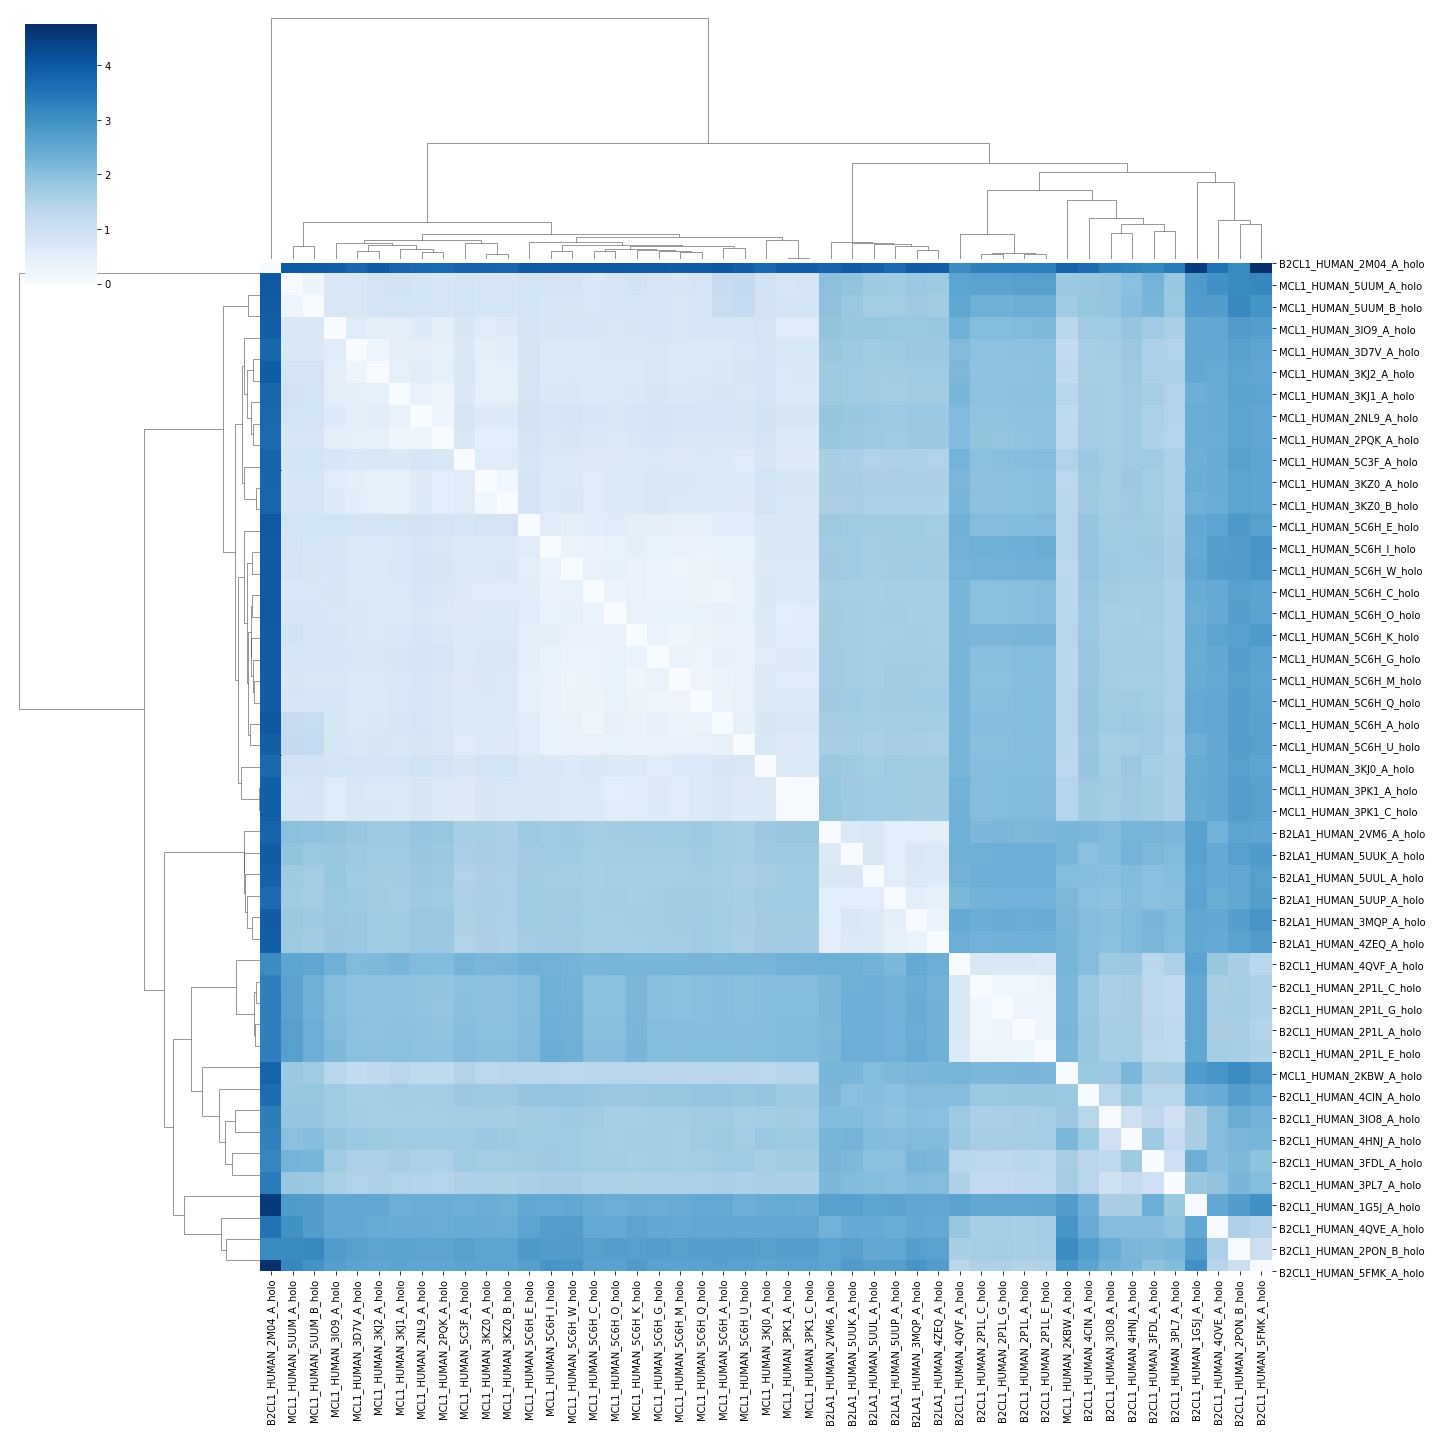

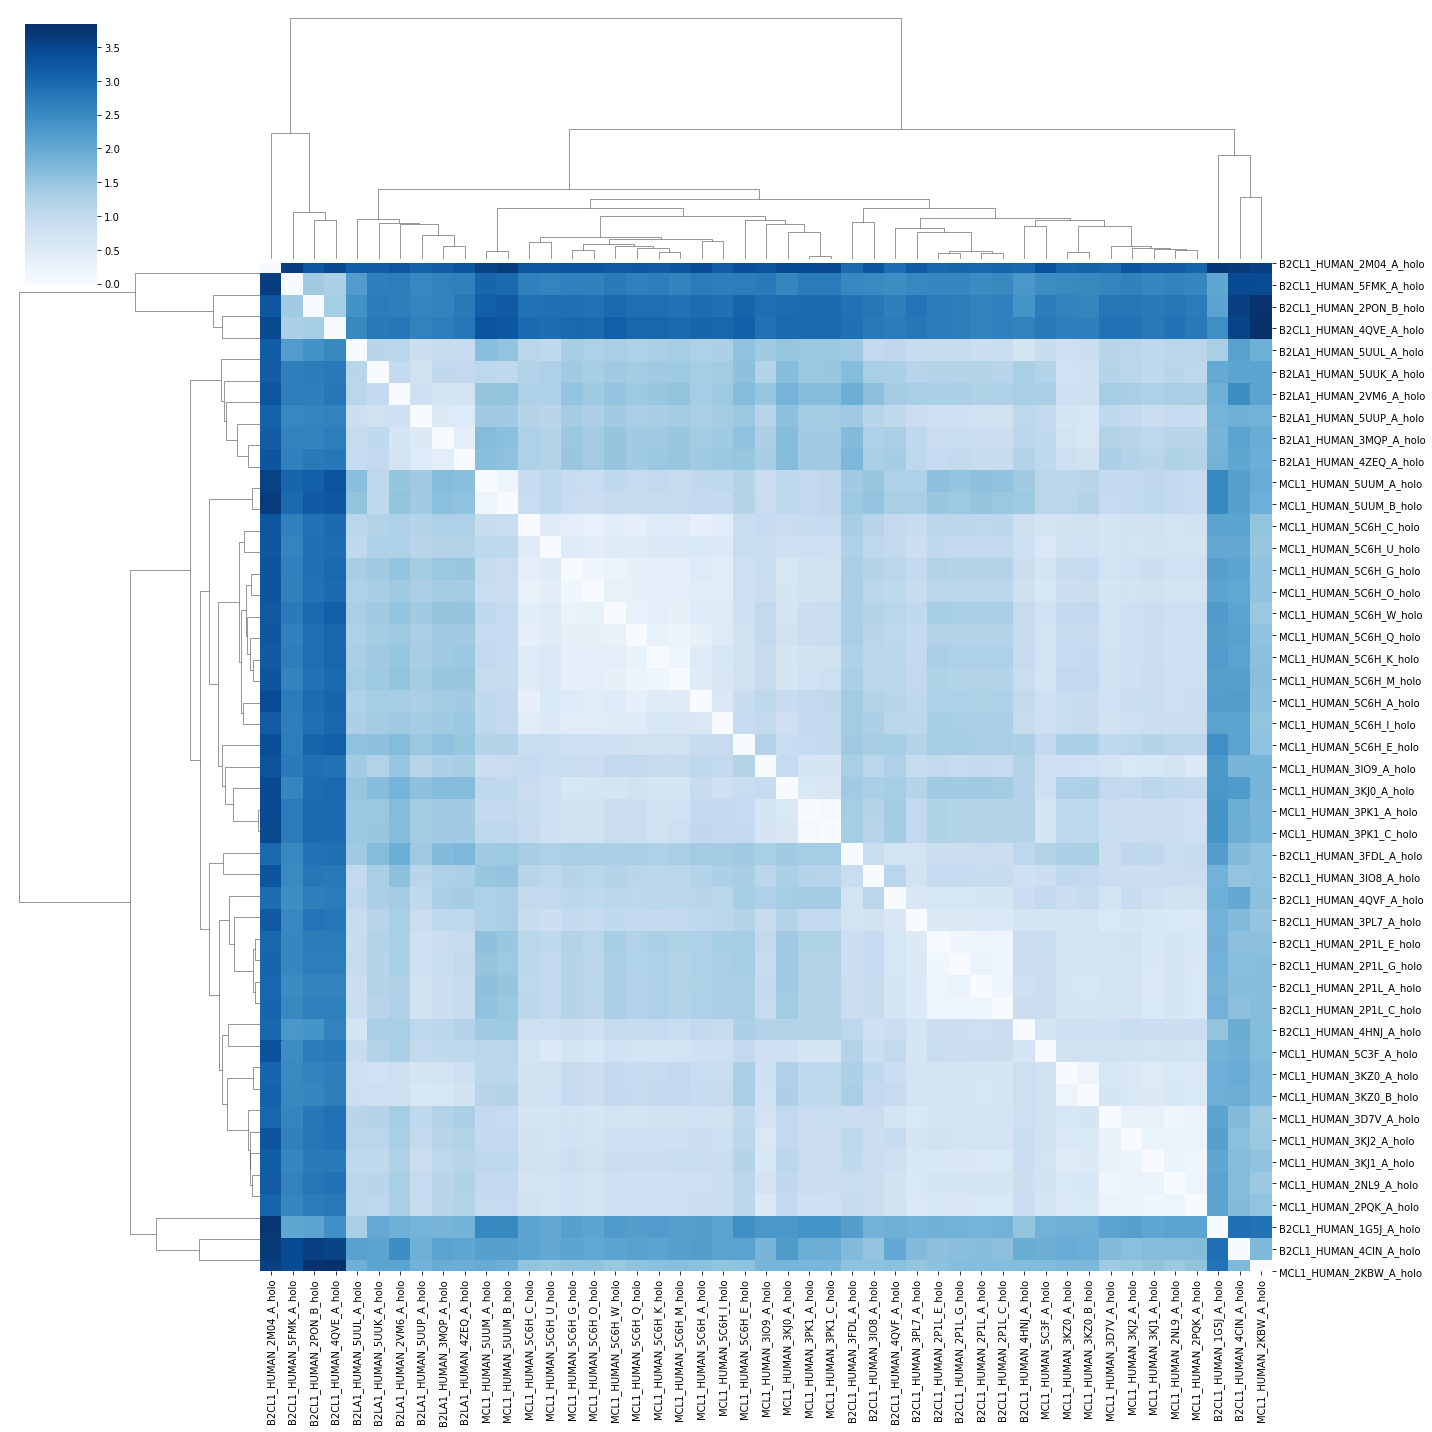

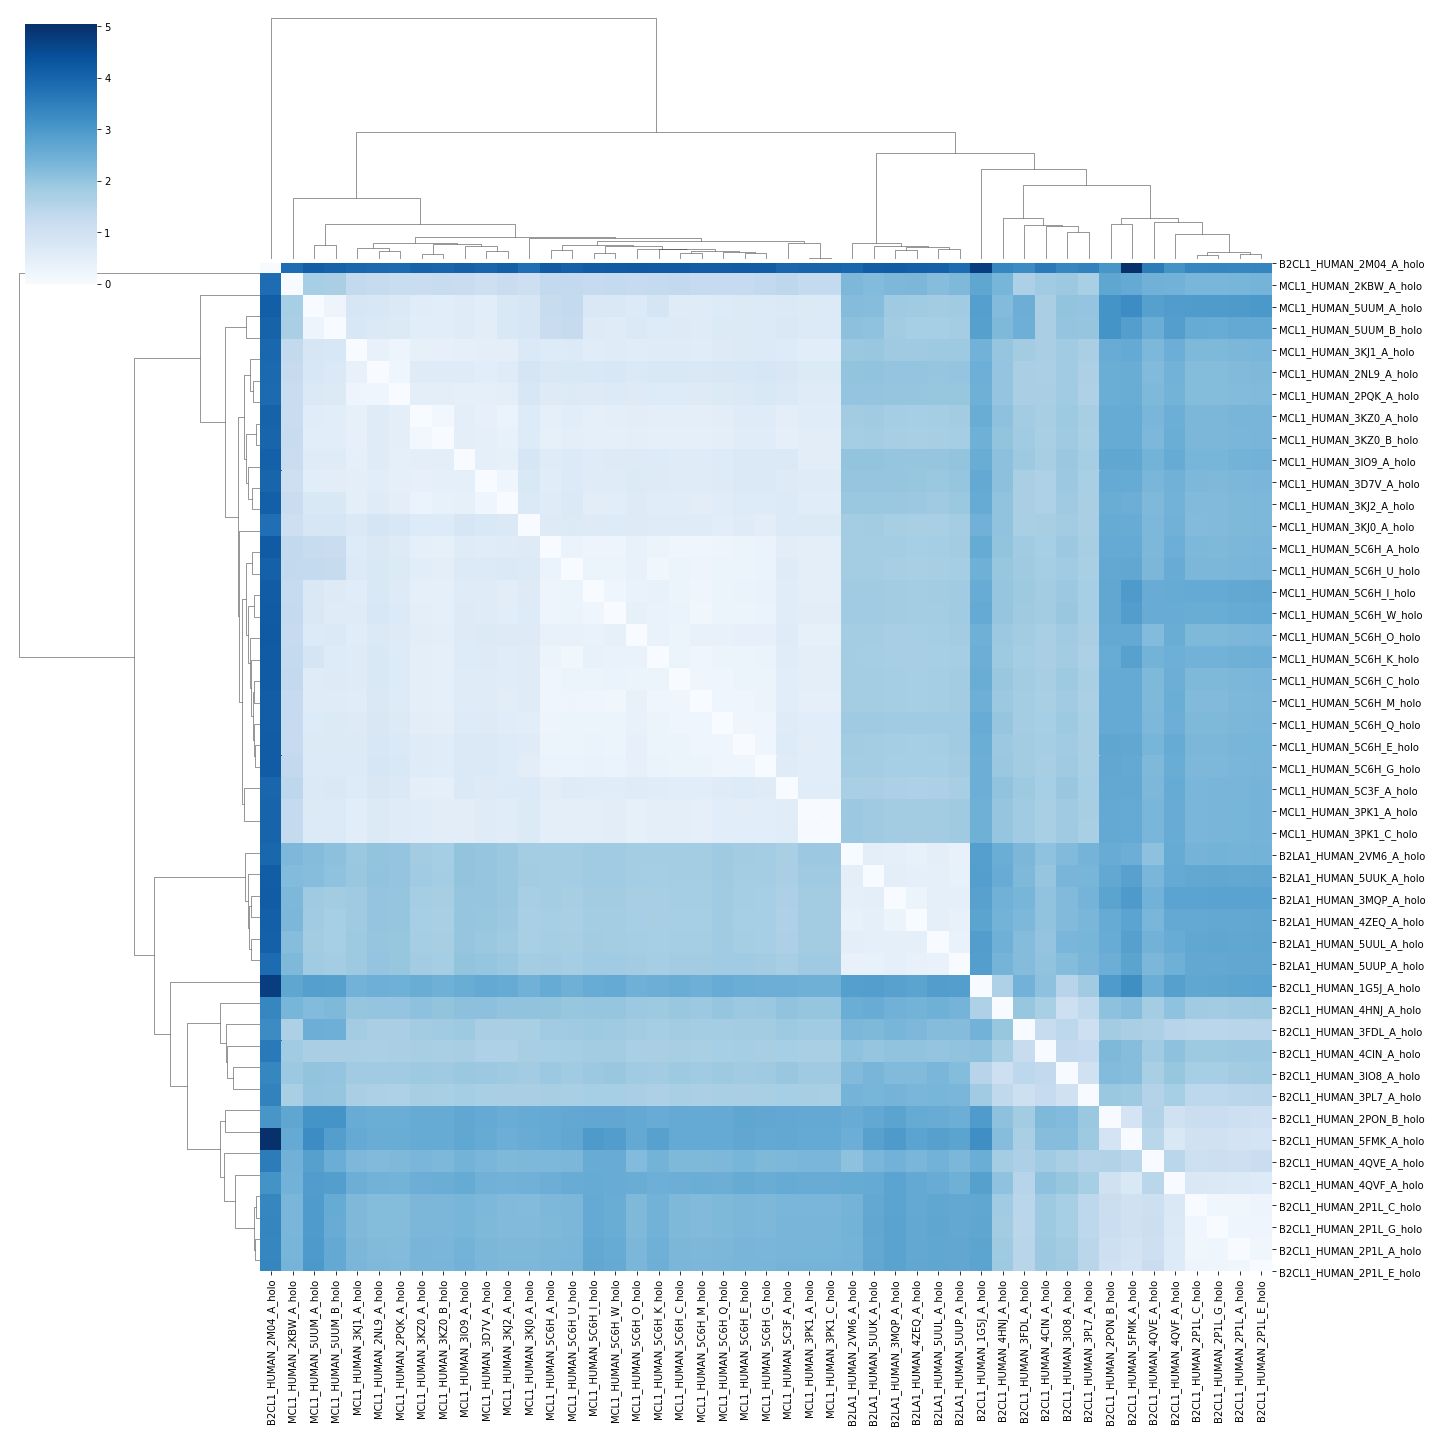

In [17]:
sns.clustermap(pd.DataFrame(AllRMSD),cmap="Blues",figsize=(20,20))
plt.show()
sns.clustermap(pd.DataFrame(PepRMSD),cmap="Blues",figsize=(20,20))
plt.show()
sns.clustermap(pd.DataFrame(RecRMSD),cmap="Blues",figsize=(20,20))
plt.show()

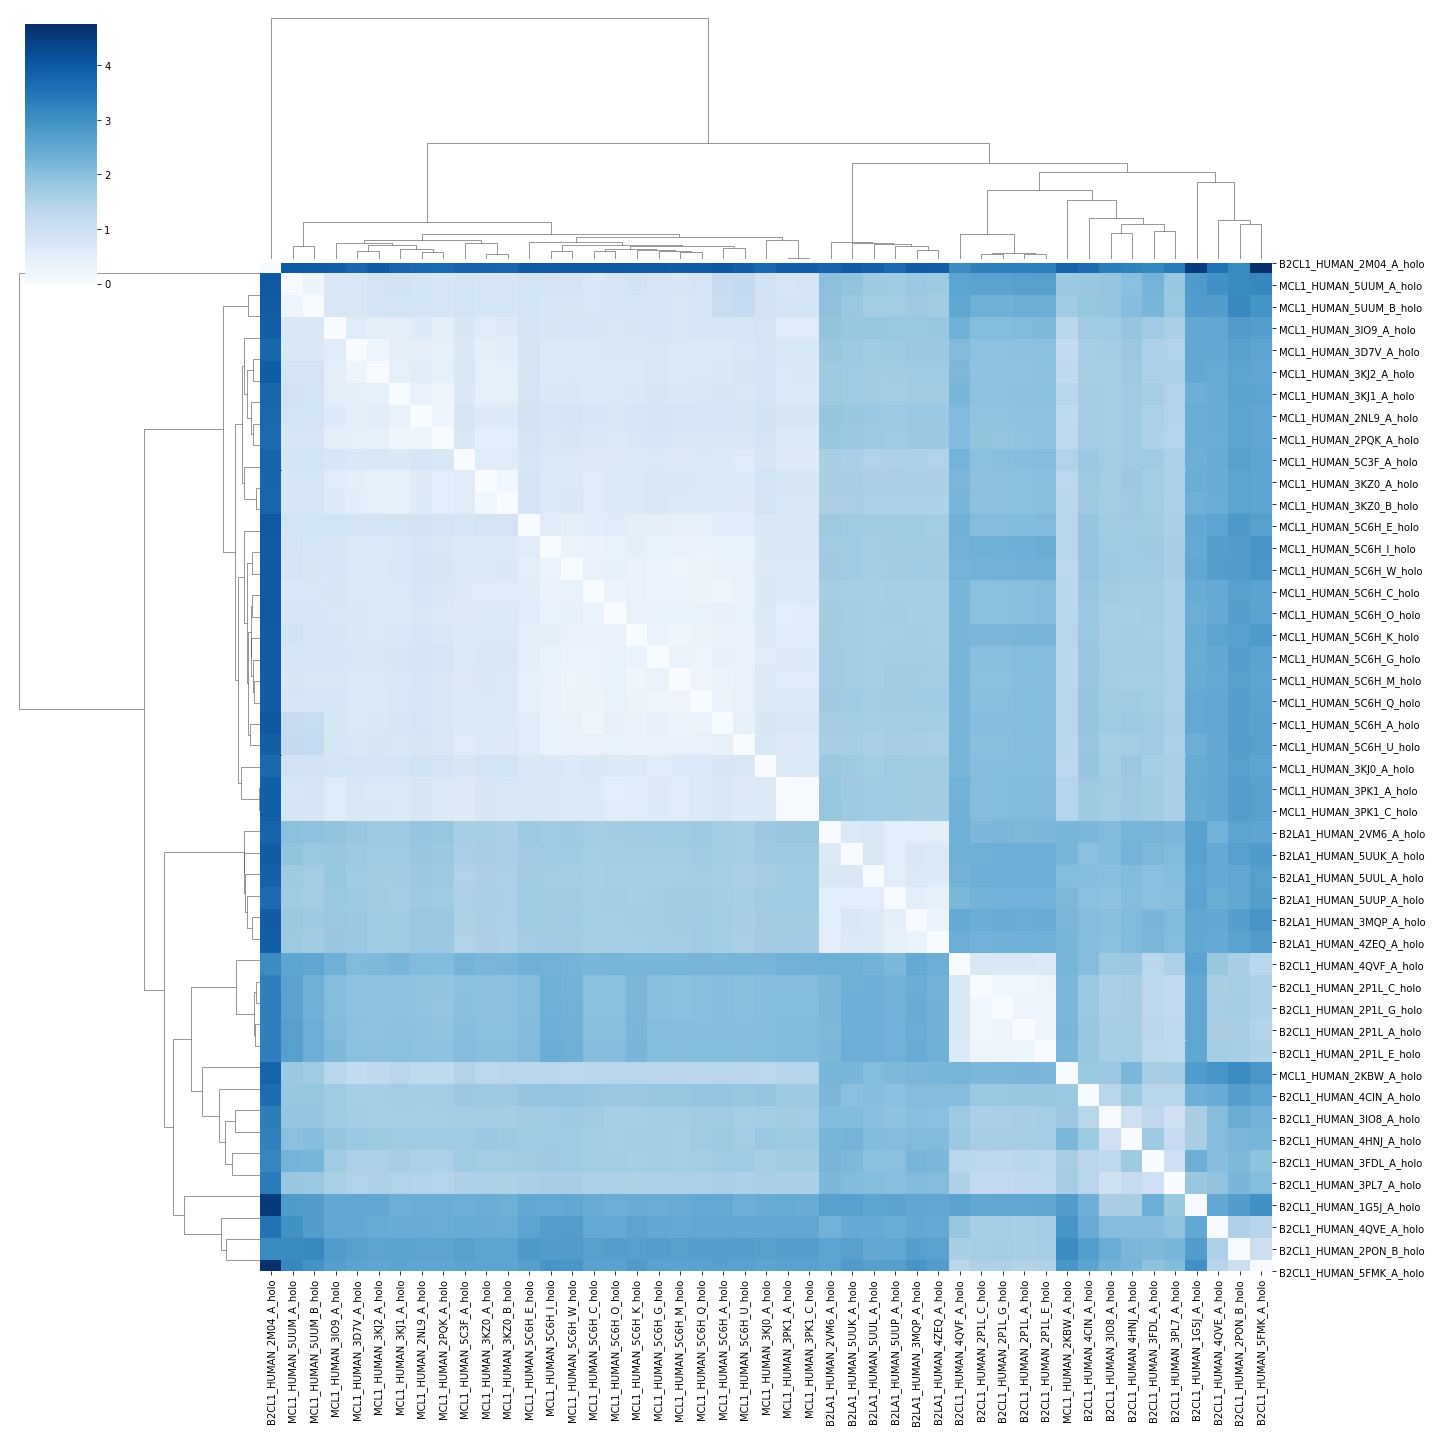

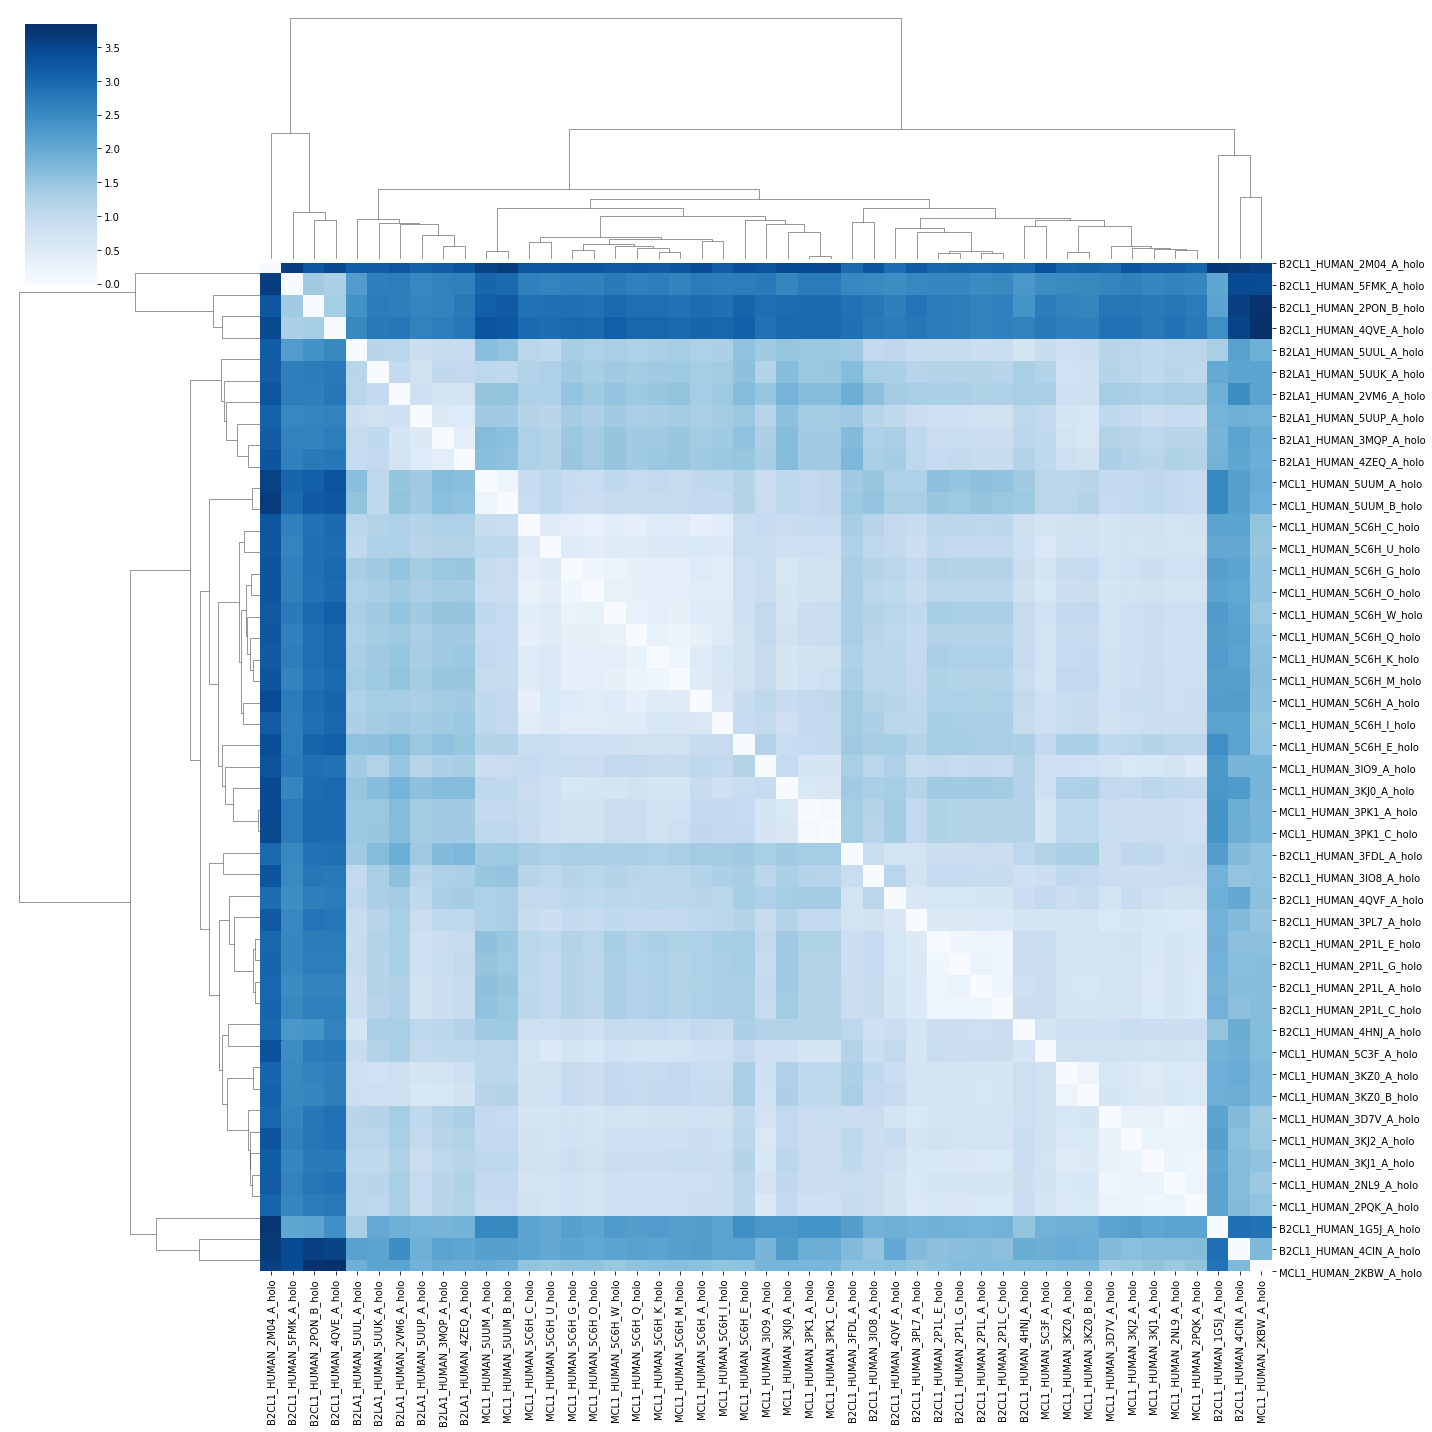

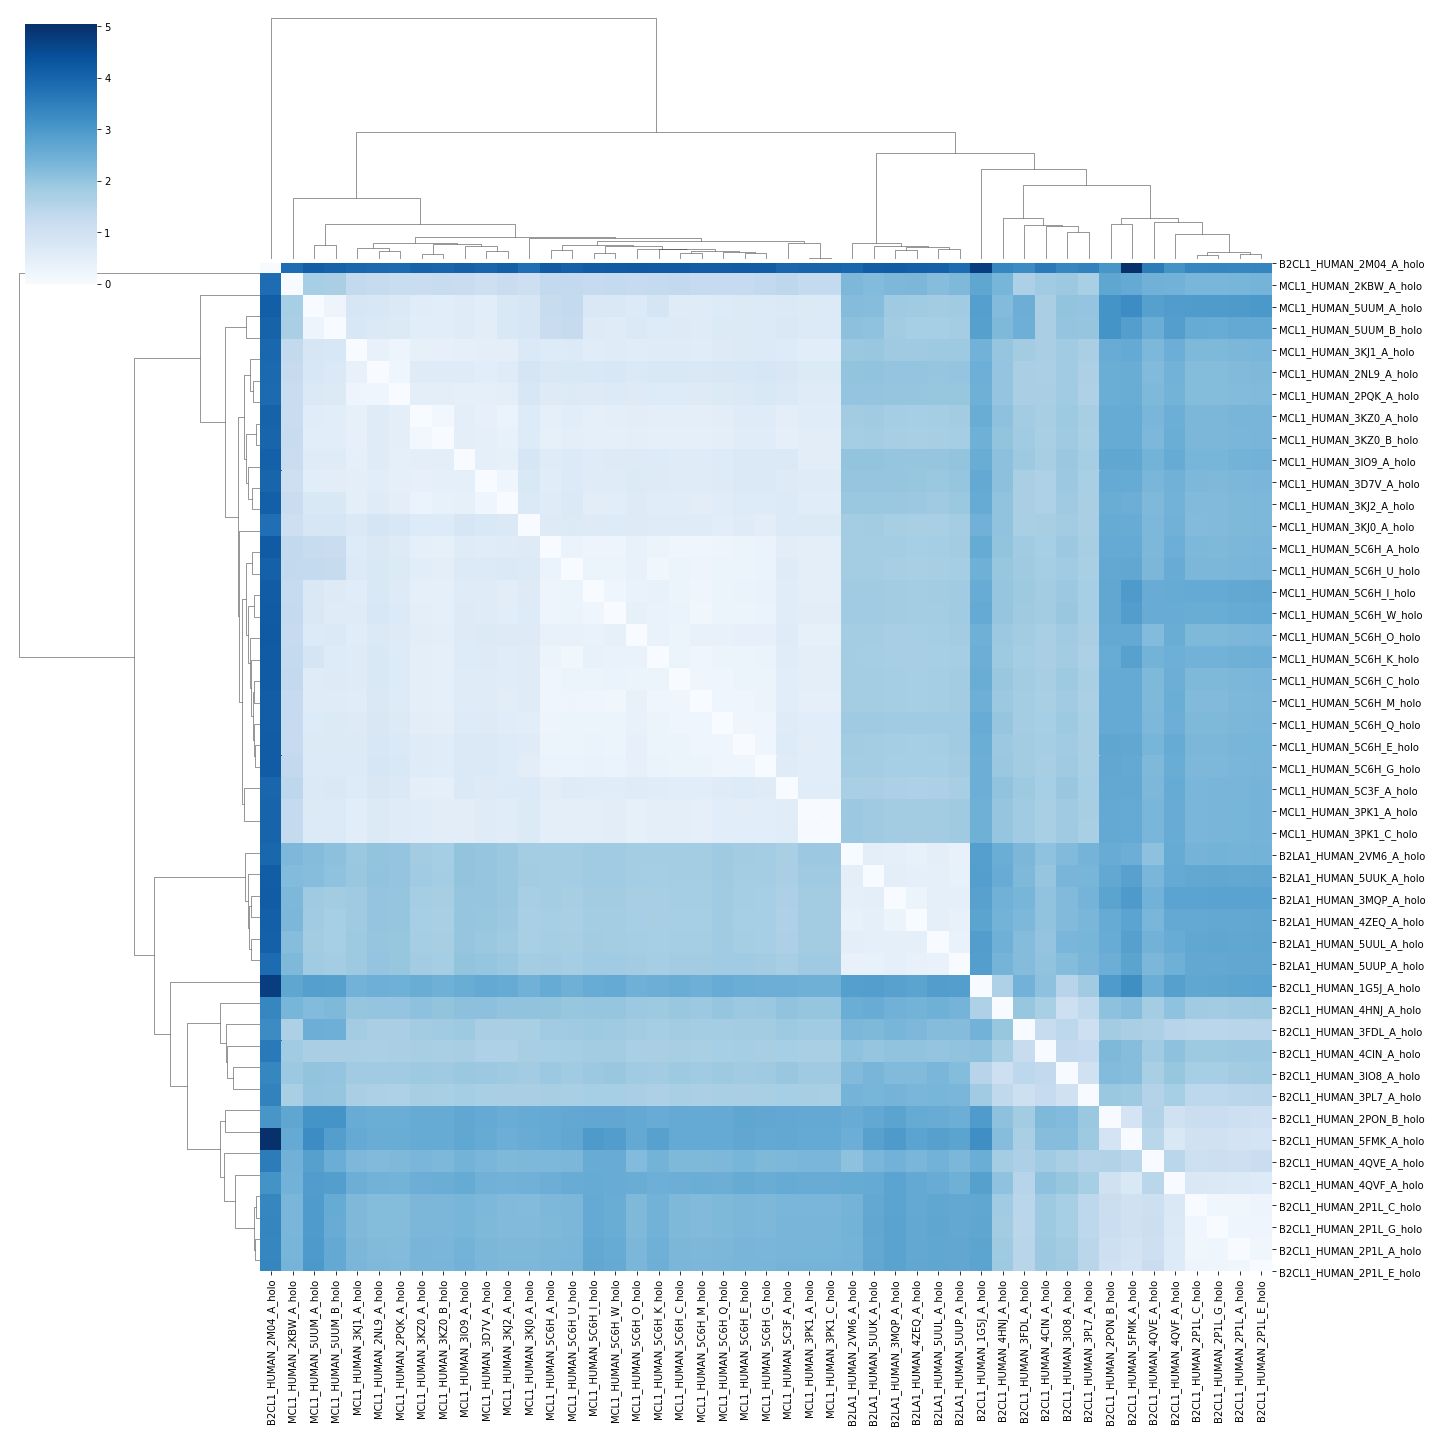

In [18]:
sns.clustermap(pd.DataFrame(AllRMSD),cmap="Blues",figsize=(20,20))
plt.show()
sns.clustermap(pd.DataFrame(PepRMSD),cmap="Blues",figsize=(20,20))
plt.show()
sns.clustermap(pd.DataFrame(RecRMSD),cmap="Blues",figsize=(20,20))
plt.show()

C:\Python37\lib\site-packages\seaborn\matrix.py:630: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


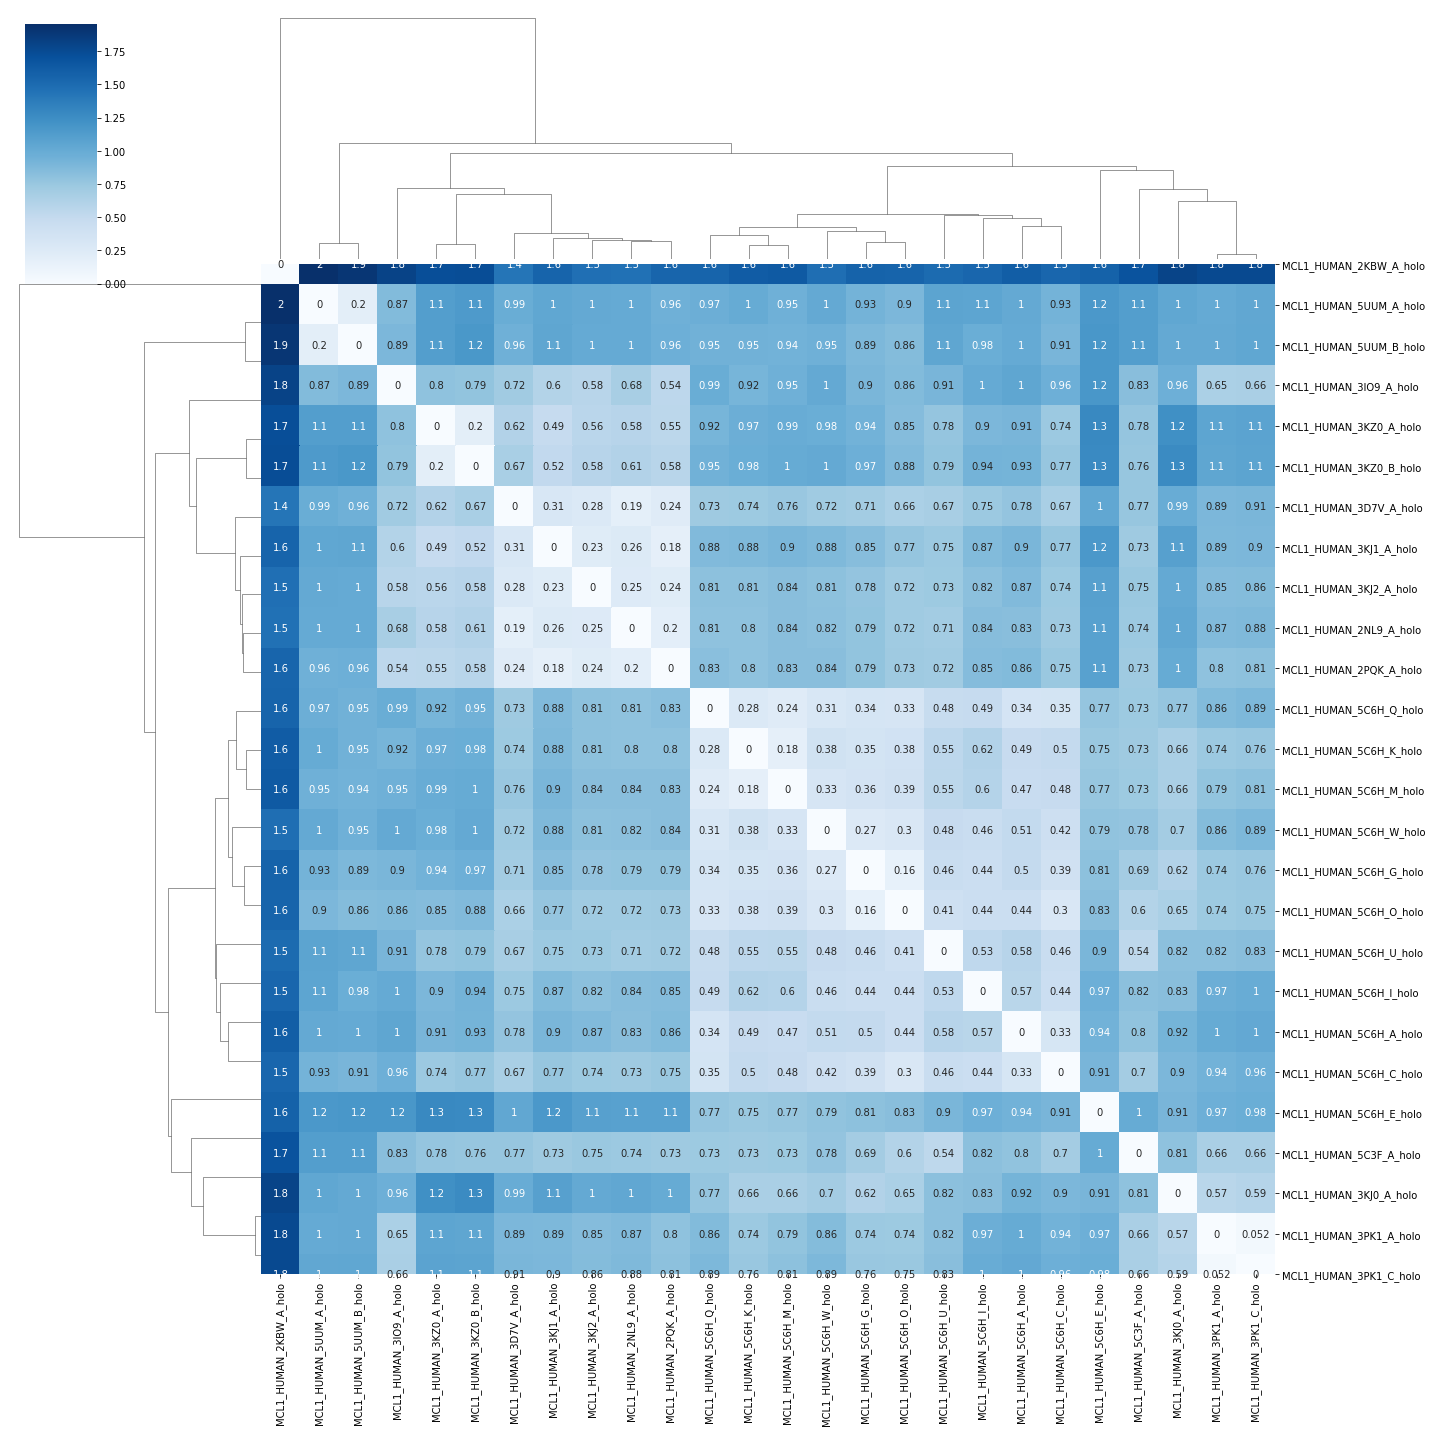

In [19]:
sns.clustermap(pd.DataFrame(PepRMSD).filter(regex="MCL1",axis=1).filter(regex="MCL1",axis=0),cmap="Blues",figsize=(20,20),annot=True)
plt.show()

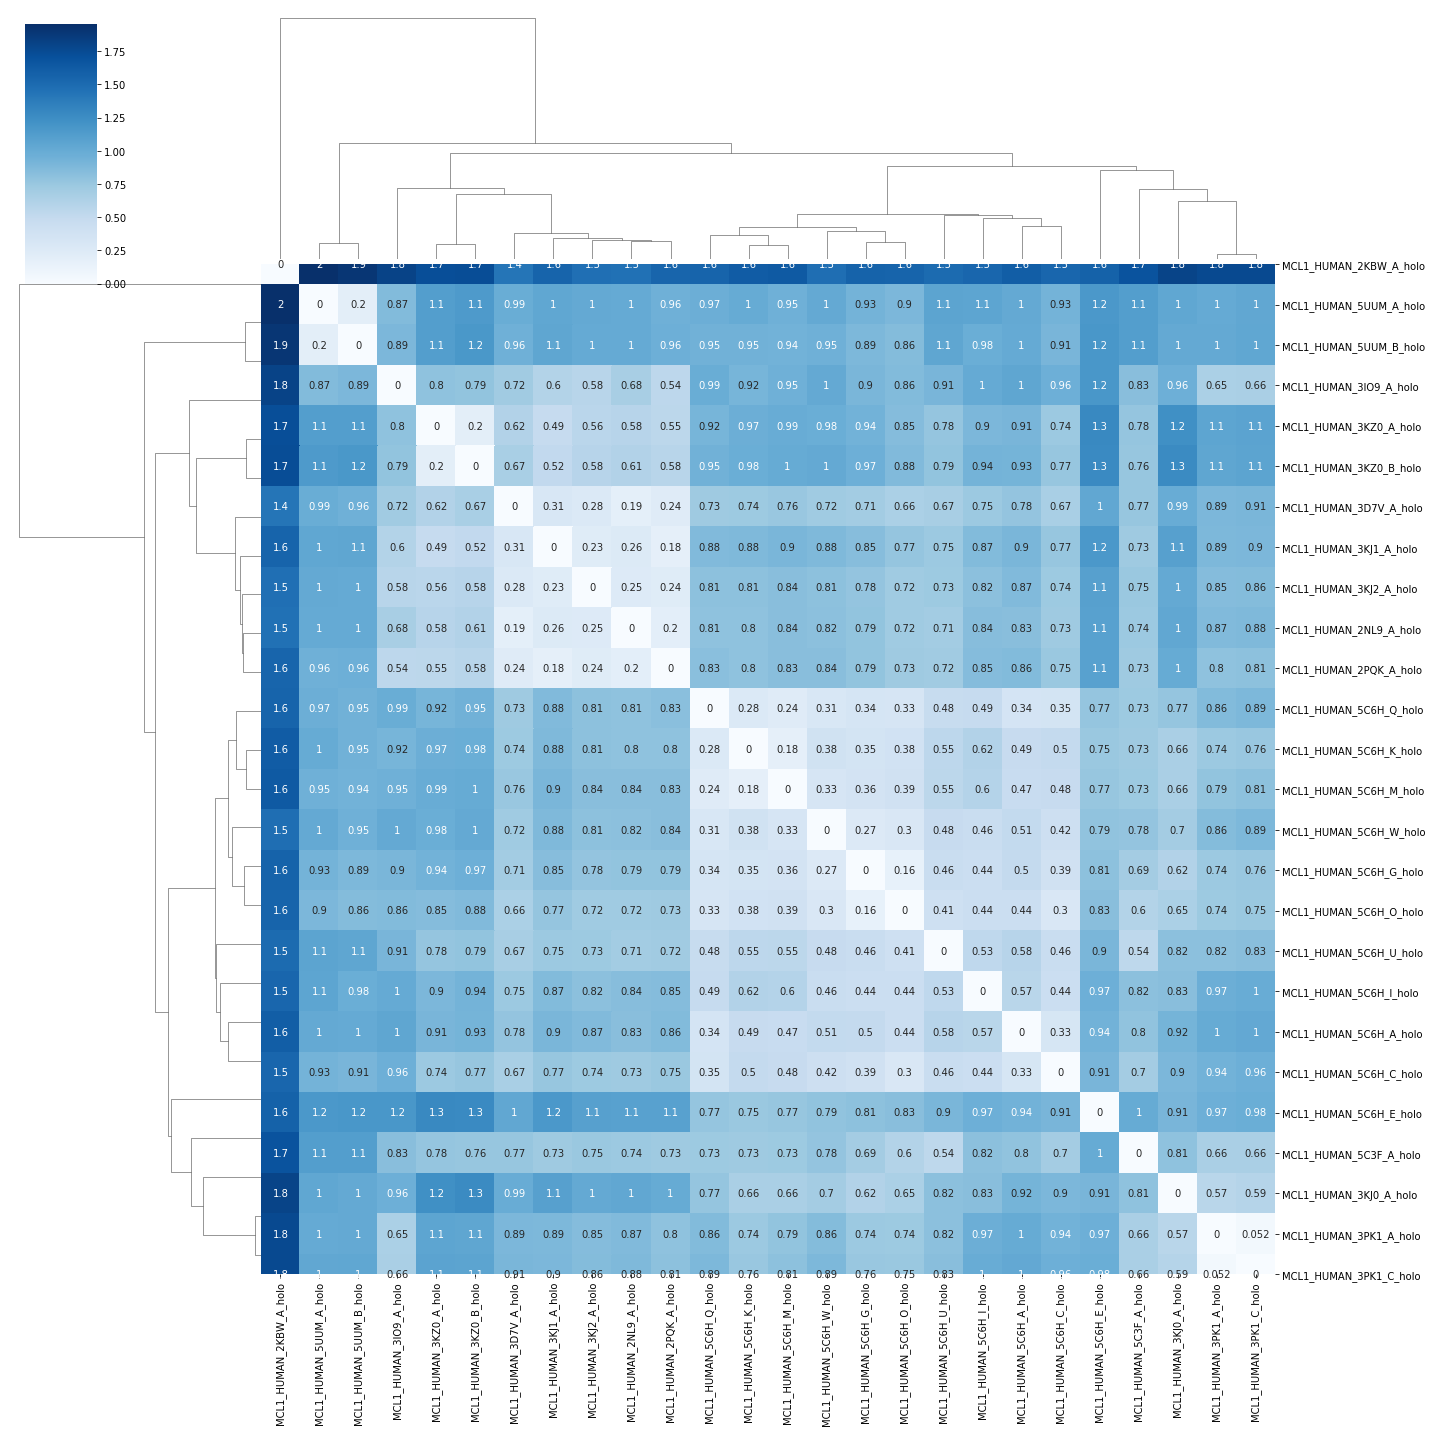

In [20]:
sns.clustermap(pd.DataFrame(PepRMSD).filter(regex="MCL1",axis=1).filter(regex="MCL1",axis=0),cmap="Blues",figsize=(20,20),annot=True)
plt.show()

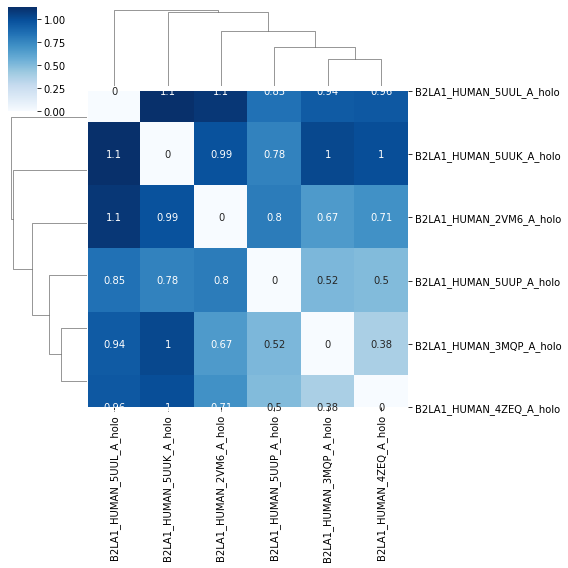

In [21]:
sns.clustermap(pd.DataFrame(PepRMSD).filter(regex="B2LA1",axis=1).filter(regex="B2LA1",axis=0),cmap="Blues",figsize=(8,8),annot=True)
plt.show()

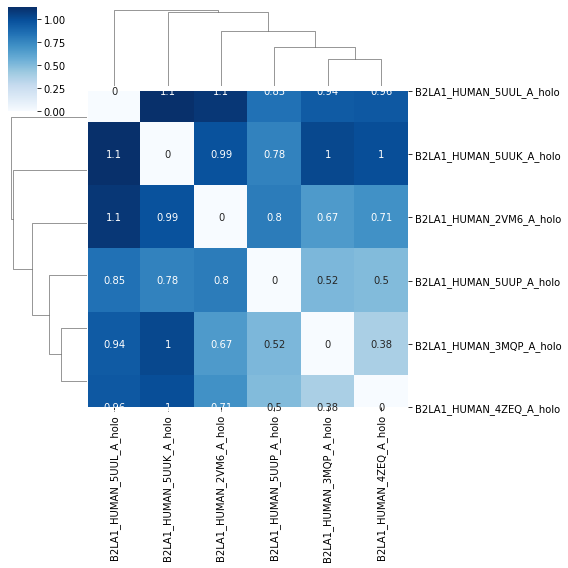

In [22]:
sns.clustermap(pd.DataFrame(PepRMSD).filter(regex="B2LA1",axis=1).filter(regex="B2LA1",axis=0),cmap="Blues",figsize=(8,8),annot=True)
plt.show()

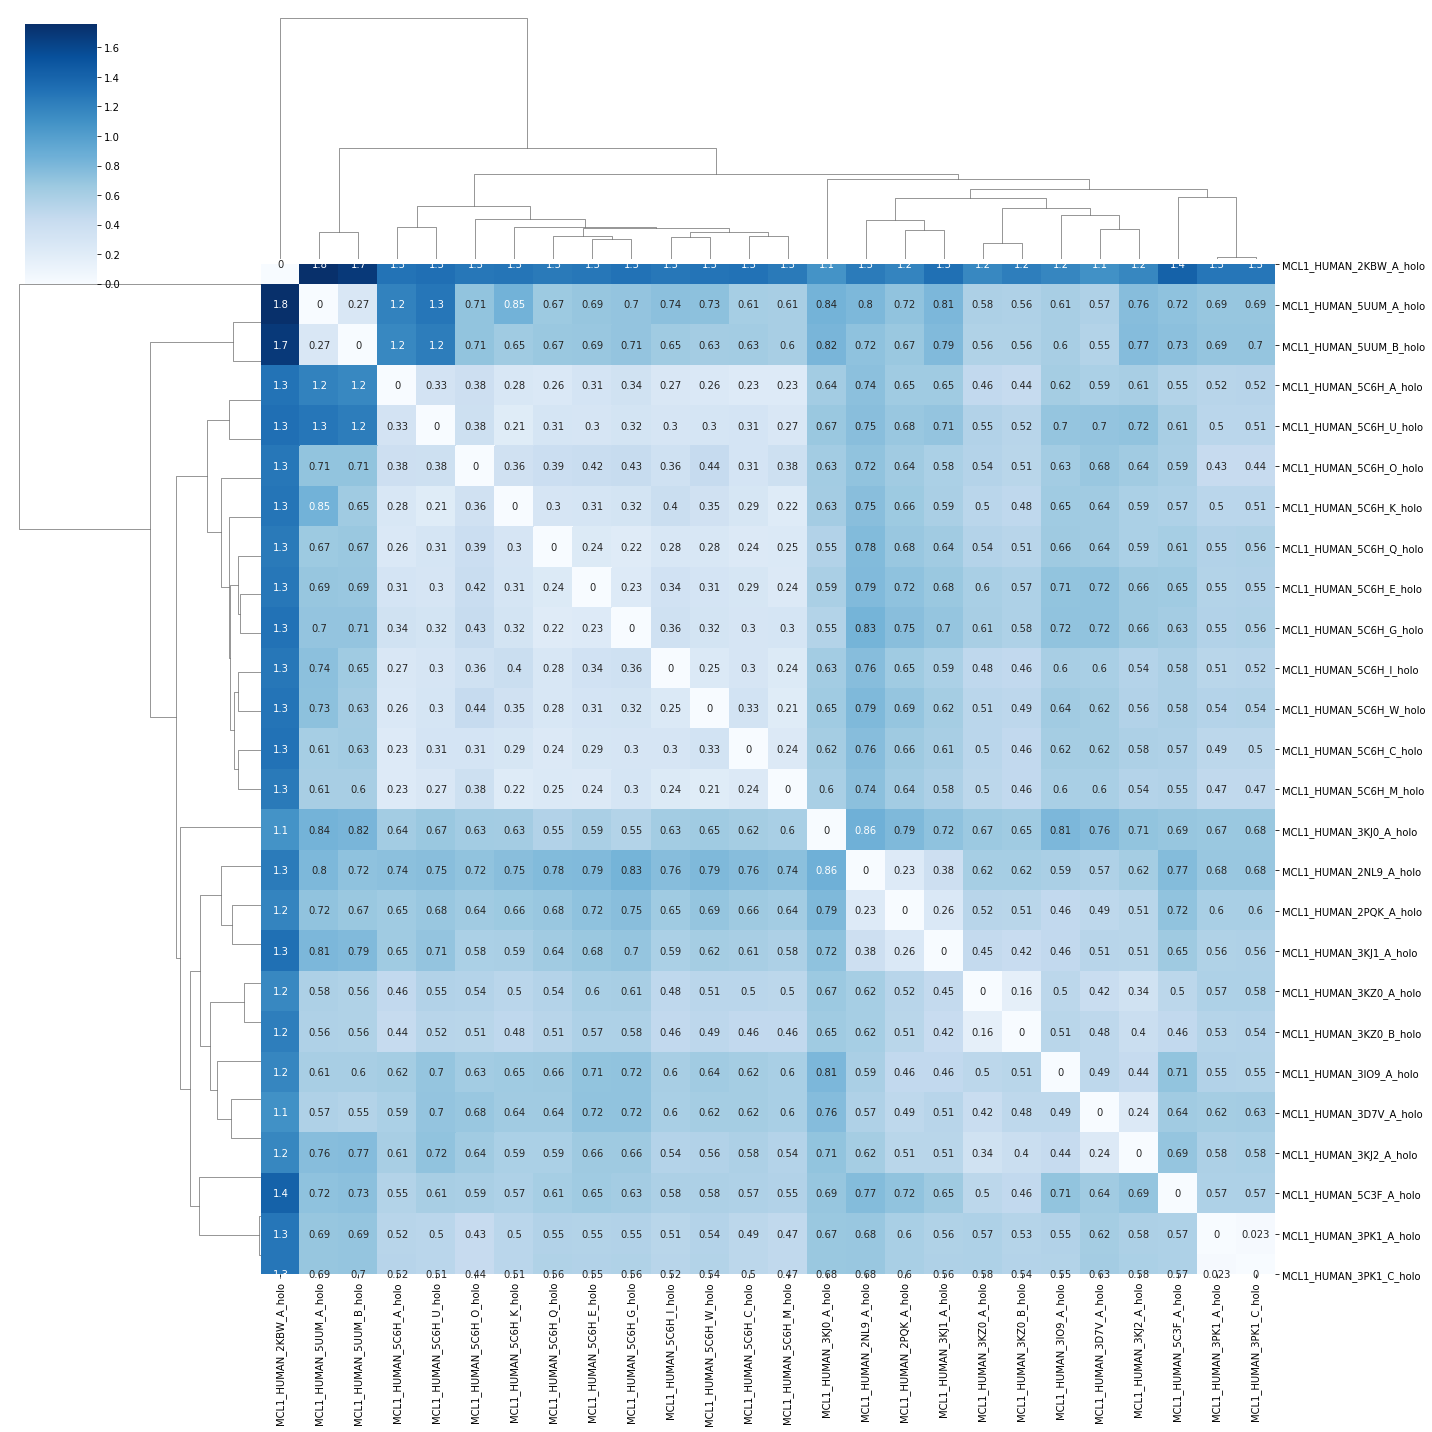

In [23]:
sns.clustermap(pd.DataFrame(RecRMSD).filter(regex="MCL1",axis=1).filter(regex="MCL1",axis=0),cmap="Blues",figsize=(20,20),annot=True)
plt.show()

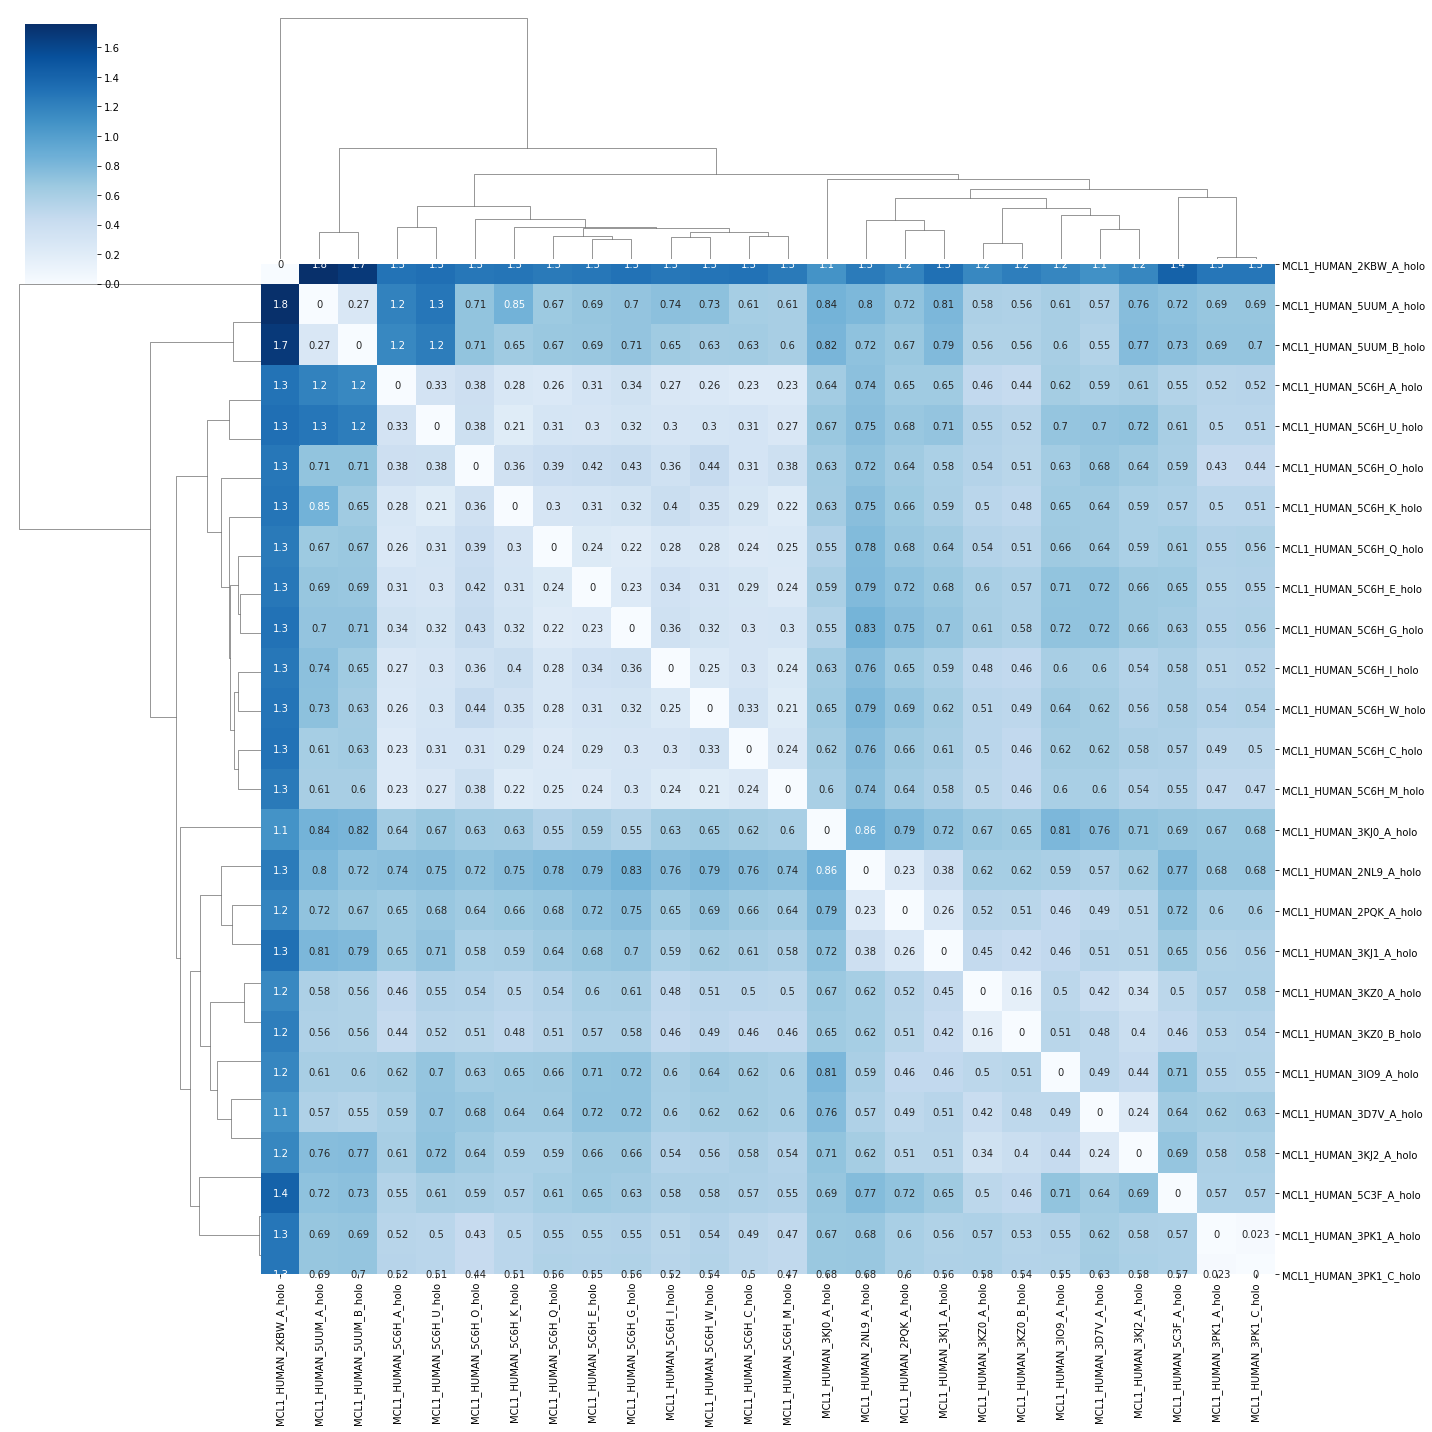

In [24]:
sns.clustermap(pd.DataFrame(RecRMSD).filter(regex="MCL1",axis=1).filter(regex="MCL1",axis=0),cmap="Blues",figsize=(20,20),annot=True)
plt.show()